# 데이터 불러오기

## 라이브러리

In [2]:
# gb_module.py

# 주요 패키지 불러오기

import pandas as pd
import numpy as np
import csv

from tqdm import tqdm
import time

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from adjustText import adjust_text

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import gb_module

# 그래프에서 한글 표시를 위한 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕으로 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호가 정상 표시되도록 설정

In [3]:
# 그래프 선명하게
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.dpi' : '100'})
%config InlineBackend.figure_format = 'retina'

## 군집 및 중심성 정보

In [13]:
def load_and_prepare_data(period_number):
    # 데이터 불러오기
    gp_info = pd.read_csv(f'result/p{period_number}_zPNNC-term_cossim.txt', encoding='utf8', sep='\t')
    glob_ctrl = pd.read_csv(f'result/p{period_number}_zWCENT-term_cossim.txt', encoding='utf8', sep='\t')
    loca_ctrl = pd.read_csv(f'result/p{period_number}_zzNC_2.0-term_cossim_edged.txt', encoding='utf8', sep='\t')
    df = gb_module.get_gp_ctrl(gp_info, glob_ctrl, loca_ctrl)
    return df

# 산점도 분석

## 시기별 산점도 그리기

In [19]:
def draw_ctrlity_scatter_plot(df, period_name):
    """
    정규화되기 이전의 rtbc와 nc 값을 사용하여 산점도를 그립니다.
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(df['rtbc'], df['nc'], s=50, c='blue', alpha=0.5)  # 산점도 그리기
    plt.title(f'Period {period_name} Scatter Plot')
    plt.xlabel('RTBC')
    plt.ylabel('NC')

    # 각 데이터 포인트에 노드 이름 표시 (선택적)
    texts = [plt.text(x, y, text, ha='right', va='bottom', fontsize=9) for x, y, text in zip(df['rtbc'], df['nc'], df['node'])]
    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='red'))

    plt.grid(True)
    plt.show()

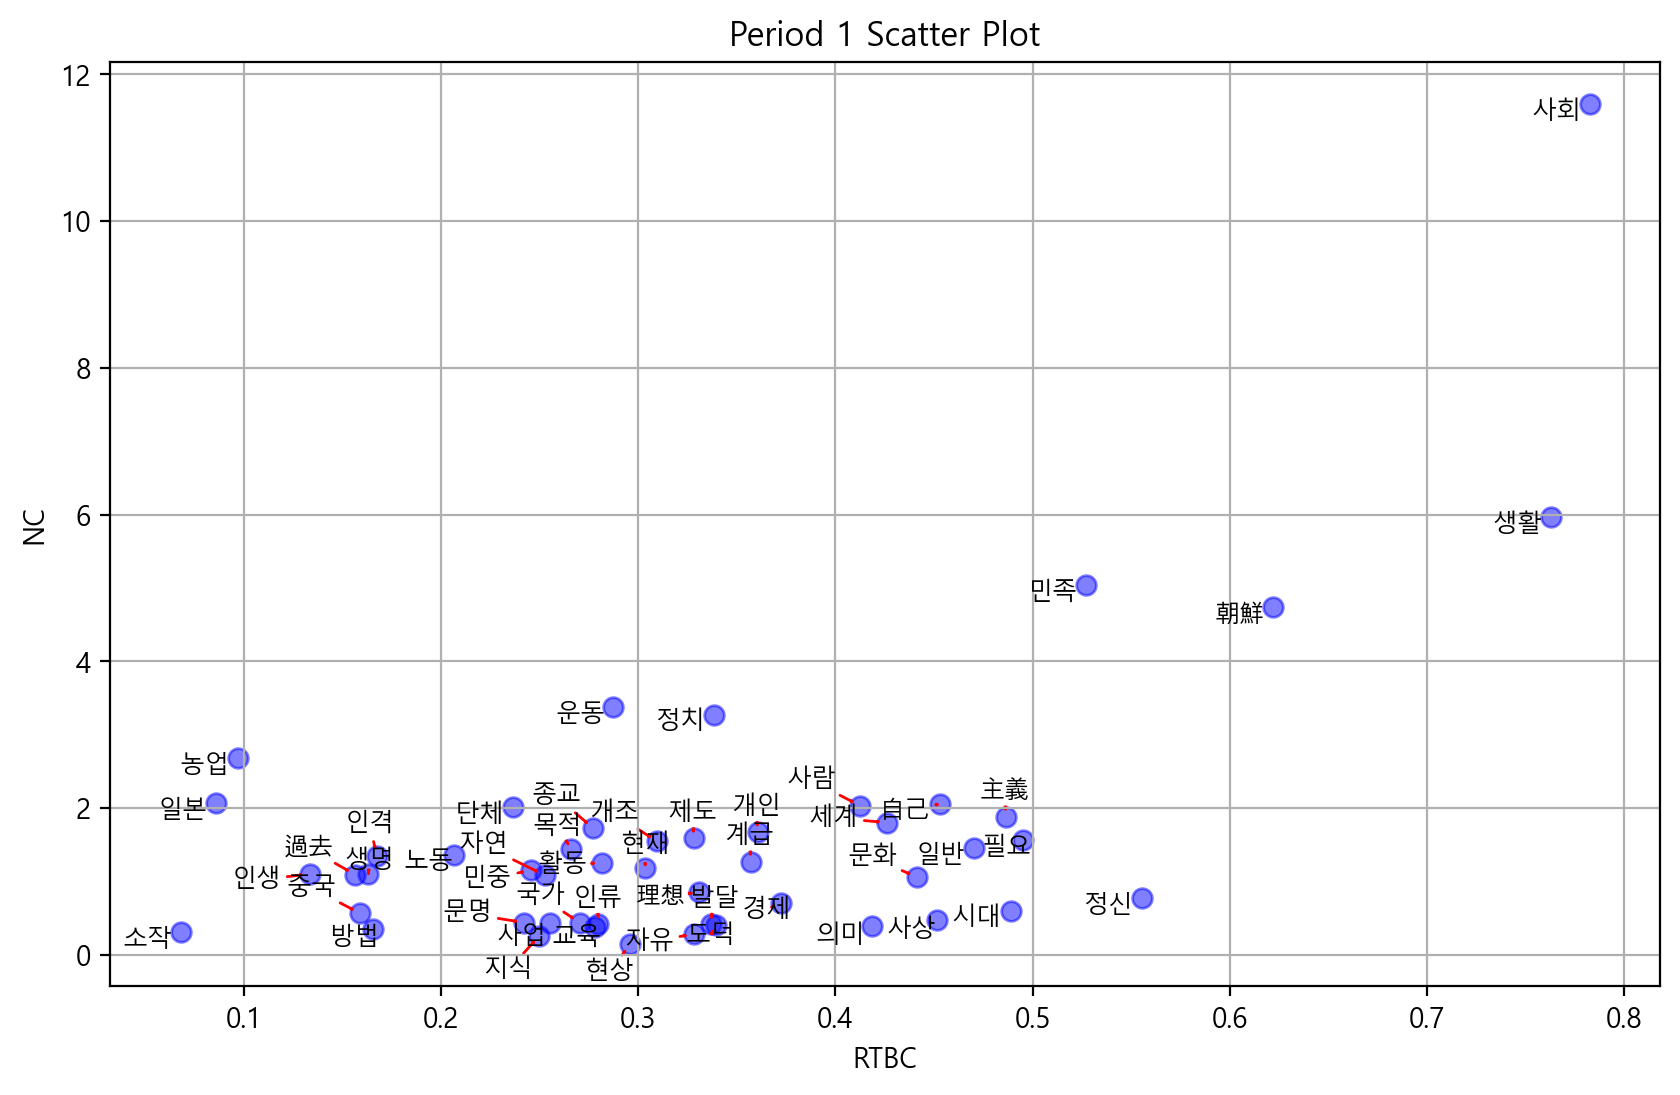

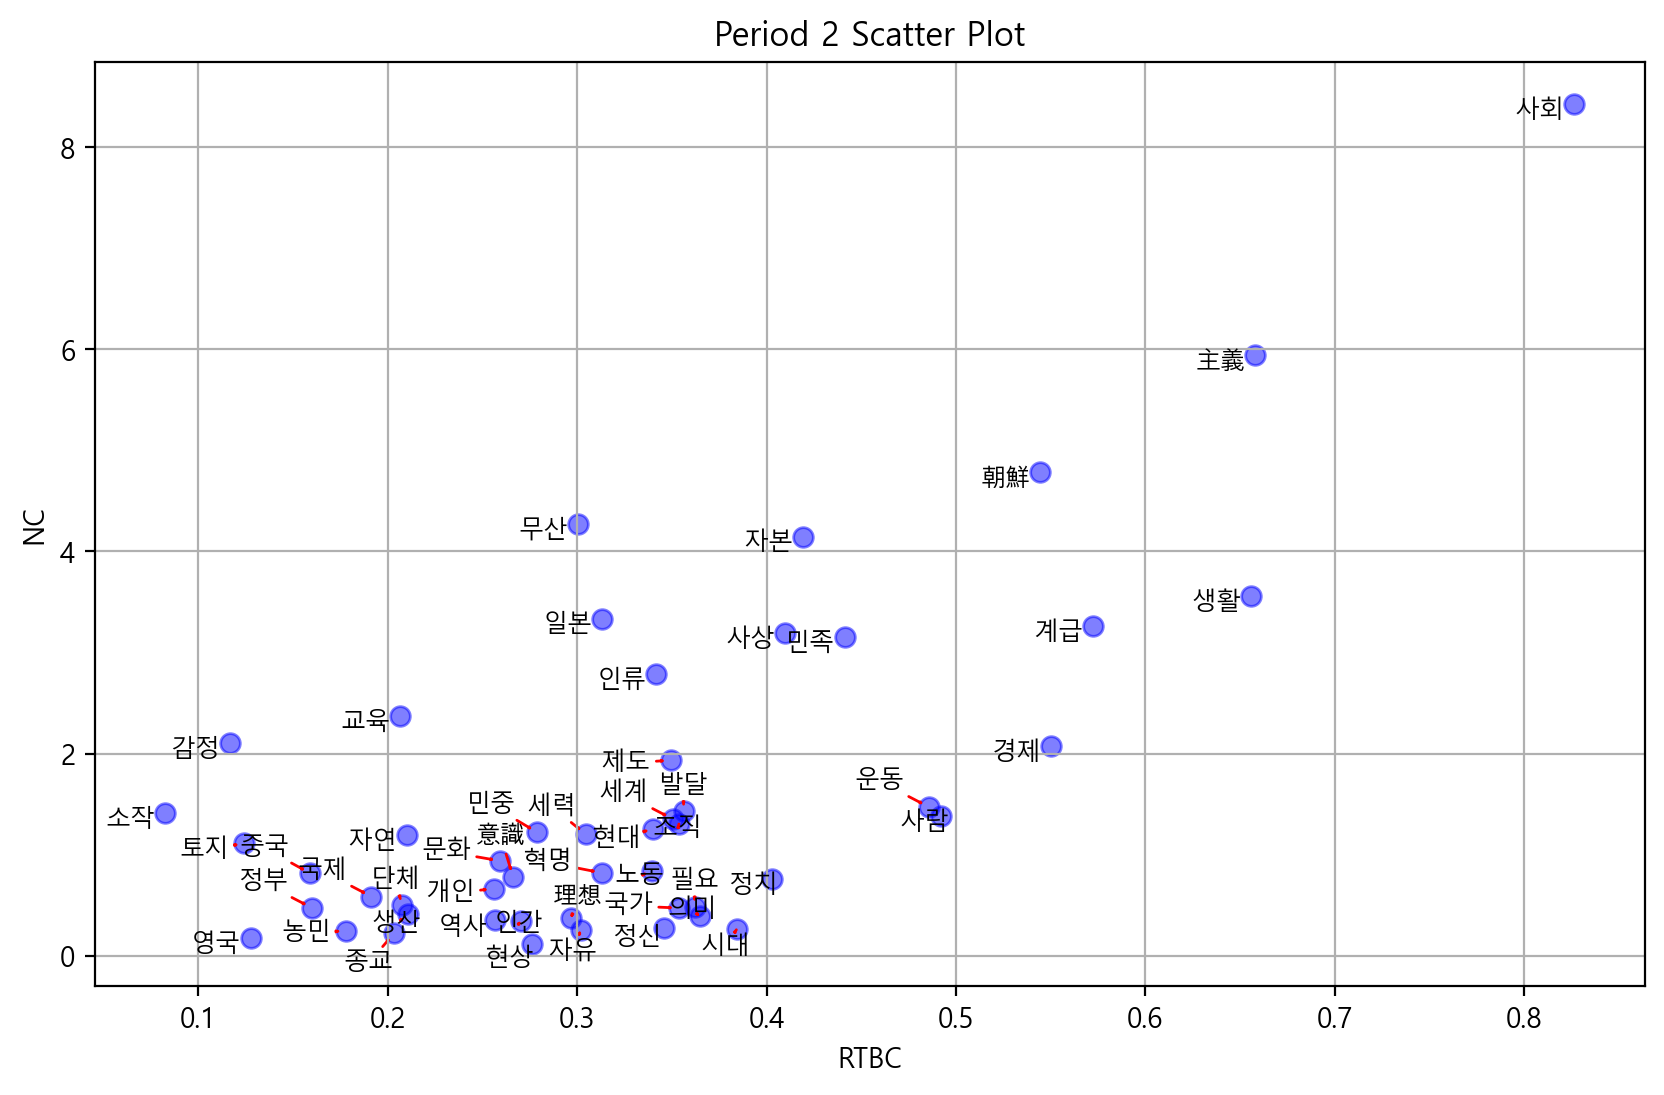

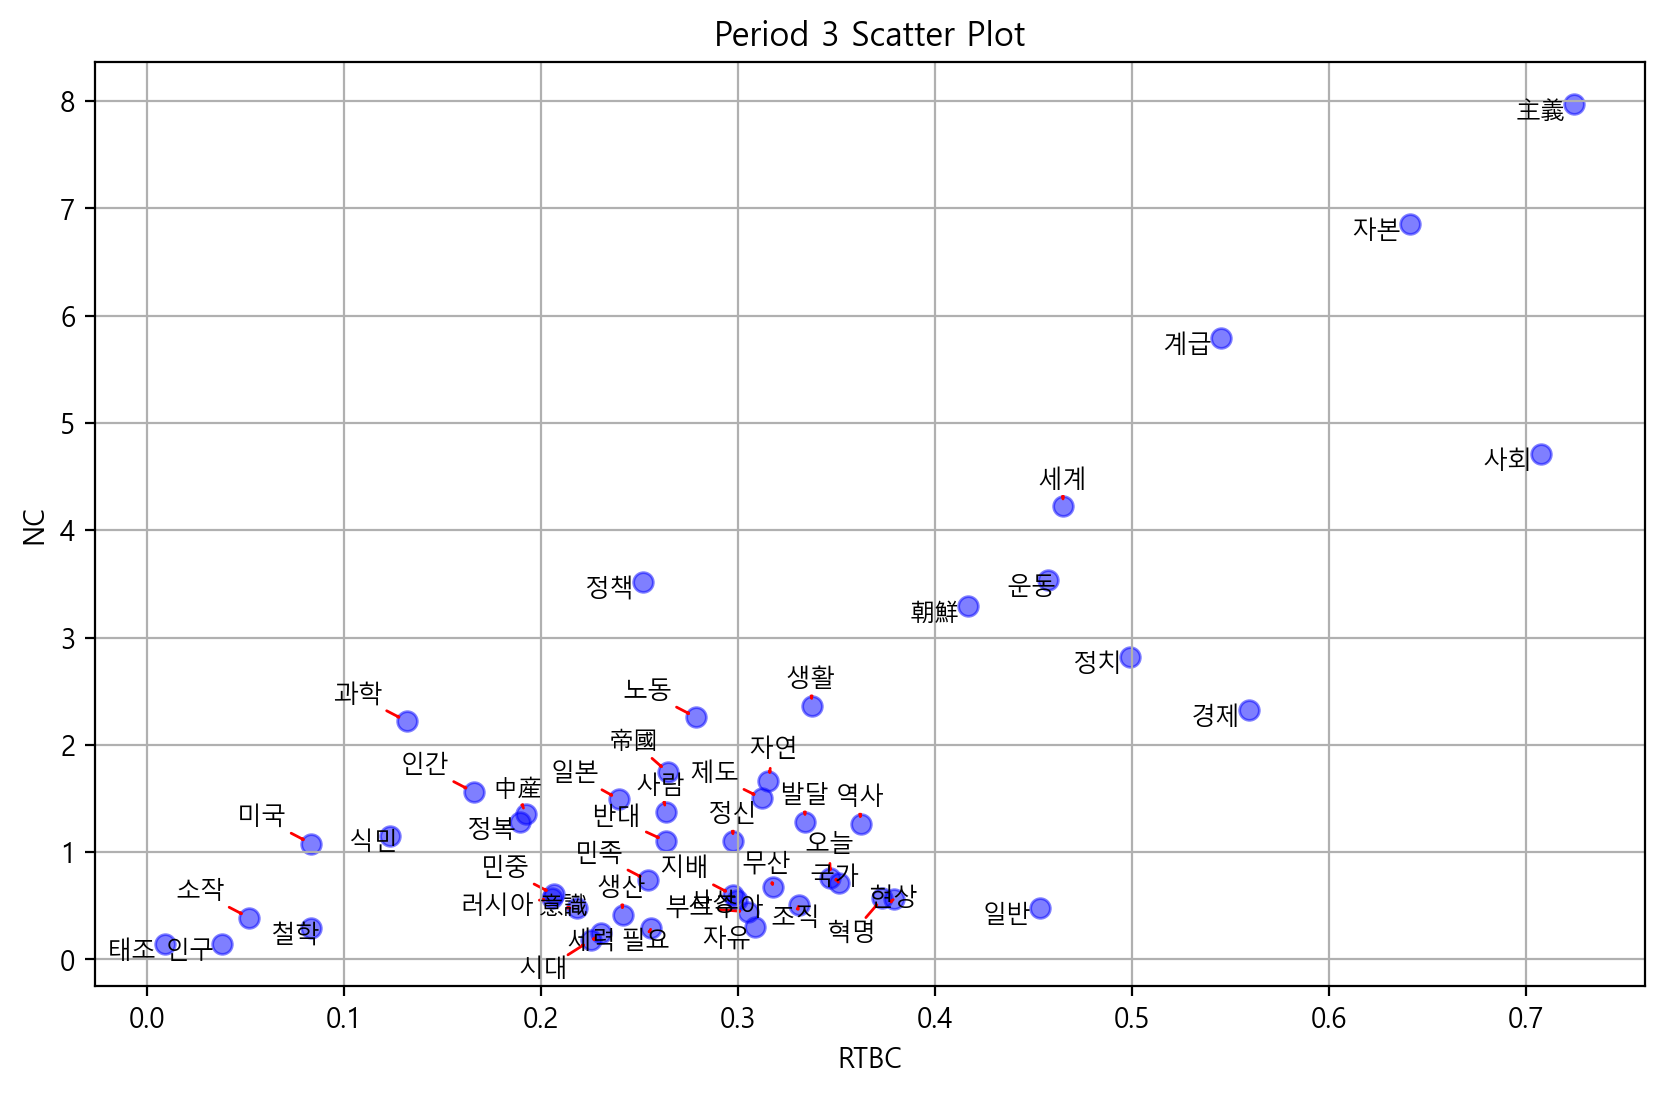

In [21]:
for i in range(1,4):
    draw_ctrlity_scatter_plot(load_and_prepare_data(i), i)

## 중요 단어 추출
- 산점도 대각선의 우상 위치

In [52]:
def select_right_upper_words(df, select_num = 4):
    df['rtbc_normalized'] = (df['rtbc'] - df['rtbc'].min()) / (df['rtbc'].max() - df['rtbc'].min())
    df['nc_normalized'] = (df['nc'] - df['nc'].min()) / (df['nc'].max() - df['nc'].min())
    df['sum_normalized'] = df['rtbc_normalized'] + df['nc_normalized']
    result = df.sort_values(by='sum_normalized', ascending=False)[:select_num]
    return result

In [58]:
p1_words = select_right_upper_words(load_and_prepare_data(1), select_num = 4)
p1_words

,node,group,rtbc,nc,rtbc_normalized,nc_normalized,sum_normalized
0,사회,1,0.78231,11.590209,1.000000,1.000000,2.000000
2,생활,3,0.76276,5.968173,0.972630,0.508876,1.481506
1,朝鮮,2,0.62160,4.738461,0.775004,0.401453,1.176457
4,민족,2,0.52721,5.040925,0.642857,0.427875,1.070732


In [59]:
p2_words = select_right_upper_words(load_and_prepare_data(2), select_num = 5)
p2_words

,node,group,rtbc,nc,rtbc_normalized,nc_normalized,sum_normalized
1,사회,1,0.82653,8.423993,1.000000,1.000000,2.000000
0,主義,1,0.65816,5.939539,0.773711,0.701129,1.474841
4,생활,3,0.65561,3.556943,0.770284,0.414512,1.184796
3,朝鮮,2,0.54422,4.788167,0.620577,0.562623,1.183200
5,계급,4,0.57228,3.266322,0.658289,0.379551,1.037840


In [60]:
p3_words = select_right_upper_words(load_and_prepare_data(3), select_num = 8)
p3_words

,node,group,rtbc,nc,rtbc_normalized,nc_normalized,sum_normalized
3,主義,2,0.72449,7.968424,1.000000,1.000000,2.000000
4,자본,2,0.64116,6.851082,0.883477,0.857273,1.740751
1,사회,2,0.70748,4.708419,0.976214,0.583574,1.559789
0,계급,1,0.54507,5.790700,0.749112,0.721822,1.470934
11,세계,2,0.46514,4.224384,0.637344,0.521745,1.159088
2,운동,3,0.45748,3.533955,0.626633,0.433551,1.060183
6,경제,3,0.55952,2.320587,0.769318,0.278558,1.047876
8,정치,3,0.49915,2.815849,0.684901,0.341822,1.026723


# 군집 비교

## 시기별 군집에 id 부여

In [66]:
p1_gp = pd.read_excel('result/p1_results.xlsx', sheet_name = 'Group_Vertices', index_col=0)
p2_gp = pd.read_excel('result/p2_results.xlsx', sheet_name = 'Group_Vertices', index_col=0)
p3_gp = pd.read_excel('result/p3_results.xlsx', sheet_name = 'Group_Vertices', index_col=0)

In [82]:
prd_gp_list = [p1_gp, p2_gp, p3_gp]
results_list = []  # 결과를 저장할 리스트

# 각 데이터 프레임을 순회하며 처리
for idx, prd_gp in enumerate(prd_gp_list, start=1):
    # 그룹별로 'node' 컬럼의 값을 리스트로 집계
    grouped = prd_gp.groupby('group')['node'].agg(list).reset_index()
    # 'group' 컬럼의 값을 원하는 형식으로 변경
    grouped['group'] = grouped['group'].apply(lambda x: f"{idx}_{x}")
    results_list.append(grouped)

# 모든 결과를 하나의 데이터 프레임으로 결합
final_df = pd.concat(results_list, ignore_index=True)

# 'group' 컬럼을 기준으로 정렬 (선택적)
final_df = final_df.sort_values(by='group').reset_index(drop=True)
final_df = final_df.set_index('group')

# 결과 출력
print(final_df)

                                                    node
group                                                   
1_1    [主義, 理想, 개인, 계급, 발달, 사회, 소작, 시대, 인격, 인류, 자유, 정...
1_10                                            [過去, 현재]
1_2         [朝鮮, 개조, 경제, 국가, 도덕, 문명, 민족, 사업, 세계, 일본, 중국]
1_3                                 [단체, 방법, 생활, 의미, 필요]
1_4                                             [自己, 사람]
1_5                             [교육, 문화, 사상, 운동, 정치, 종교]
1_6                                         [노동, 농업, 자연]
1_7                                             [민중, 일반]
1_8                                             [생명, 활동]
1_9                                             [목적, 인생]
2_1    [主義, 개인, 교육, 국가, 단체, 문화, 사상, 사회, 시대, 자유, 정부, 정...
2_2             [朝鮮, 경제, 농민, 사람, 영국, 의미, 일본, 자연, 정치, 중국]
2_3                 [理想, 감정, 민족, 생활, 세계, 역사, 인간, 인류, 종교]
2_4                             [意識, 계급, 국제, 무산, 운동, 혁명]
2_5                                     [노동, 발달, 생산, 자본]
2_6                            

## 군집 간 유사도 산출
- 코사인유사도 0.33 이상

In [78]:
# 유사도 계산 단순화

def calculate_similarity_matrix(data):
    # CountVectorizer를 사용해 단어 빈도를 벡터화
    vectorizer = CountVectorizer()
    keys = list(data.keys())
    # 초기 유사도 매트릭스 설정
    similarity_matrix = np.zeros((len(keys), len(keys)))

    # 모든 키 조합에 대해 유사도 계산
    for i, key1 in enumerate(keys):
        for j, key2 in enumerate(keys):
            if i >= j:  # 유사도 매트릭스의 대칭성을 이용
                continue
            # 두 군집의 단어 리스트를 하나의 문자열로 결합
            corpus = [' '.join(data[key1]), ' '.join(data[key2])]
            # 벡터화 수행
            X = vectorizer.fit_transform(corpus).toarray()
            # 유사도 계산
            similarity = cosine_similarity([X[0]], [X[1]])[0][0]
            # 유사도 매트릭스 업데이트
            similarity_matrix[i, j] = similarity_matrix[j, i] = similarity

    return pd.DataFrame(similarity_matrix, index=keys, columns=keys)

In [79]:
# 유사도 필터링 단순화

def filter_similarities_above_threshold(similarity_df, threshold=0.3):
    # 유사도 임계값 이상인 값만 필터링
    # np.triu는 상삼각행렬을 만들어 대각선 위의 값만 비교하도록 함
    mask = np.triu(np.ones(similarity_df.shape), k=1).astype(bool)
    filtered_df = similarity_df.where(mask & (similarity_df >= threshold))
    # 결과를 tidy data 형태로 변환
    return filtered_df.stack().reset_index().rename(columns={'level_0': 'Group1', 'level_1': 'Group2', 0: 'Similarity'})

In [118]:
# 데이터 준비
data = final_df.to_dict()['node']

# 유사도 매트릭스 계산
similarity_matrix_df = calculate_similarity_matrix(data)

# 유사도 임계값 이상의 군집 쌍 추출 (예시에서는 0.33로 설정)
filtered_similarity_df = filter_similarities_above_threshold(similarity_matrix_df, 0.33)

# 결과 출력
print(filtered_similarity_df.sort_values(by=['Group1', 'Group2'], ascending=True))

   Group1 Group2  Similarity
0     1_1    2_1    0.500979
1     1_1    3_2    0.440386
2     1_2    2_2    0.381385
3     1_4    3_6    0.500000
4     1_6    3_5    0.333333
5     1_7    2_6    0.500000
6     2_1    3_2    0.517088
7     2_2    3_3    0.350823
8     2_3    3_4    0.333333
9     2_4    3_1    0.500000
10    2_5    3_2    0.426401


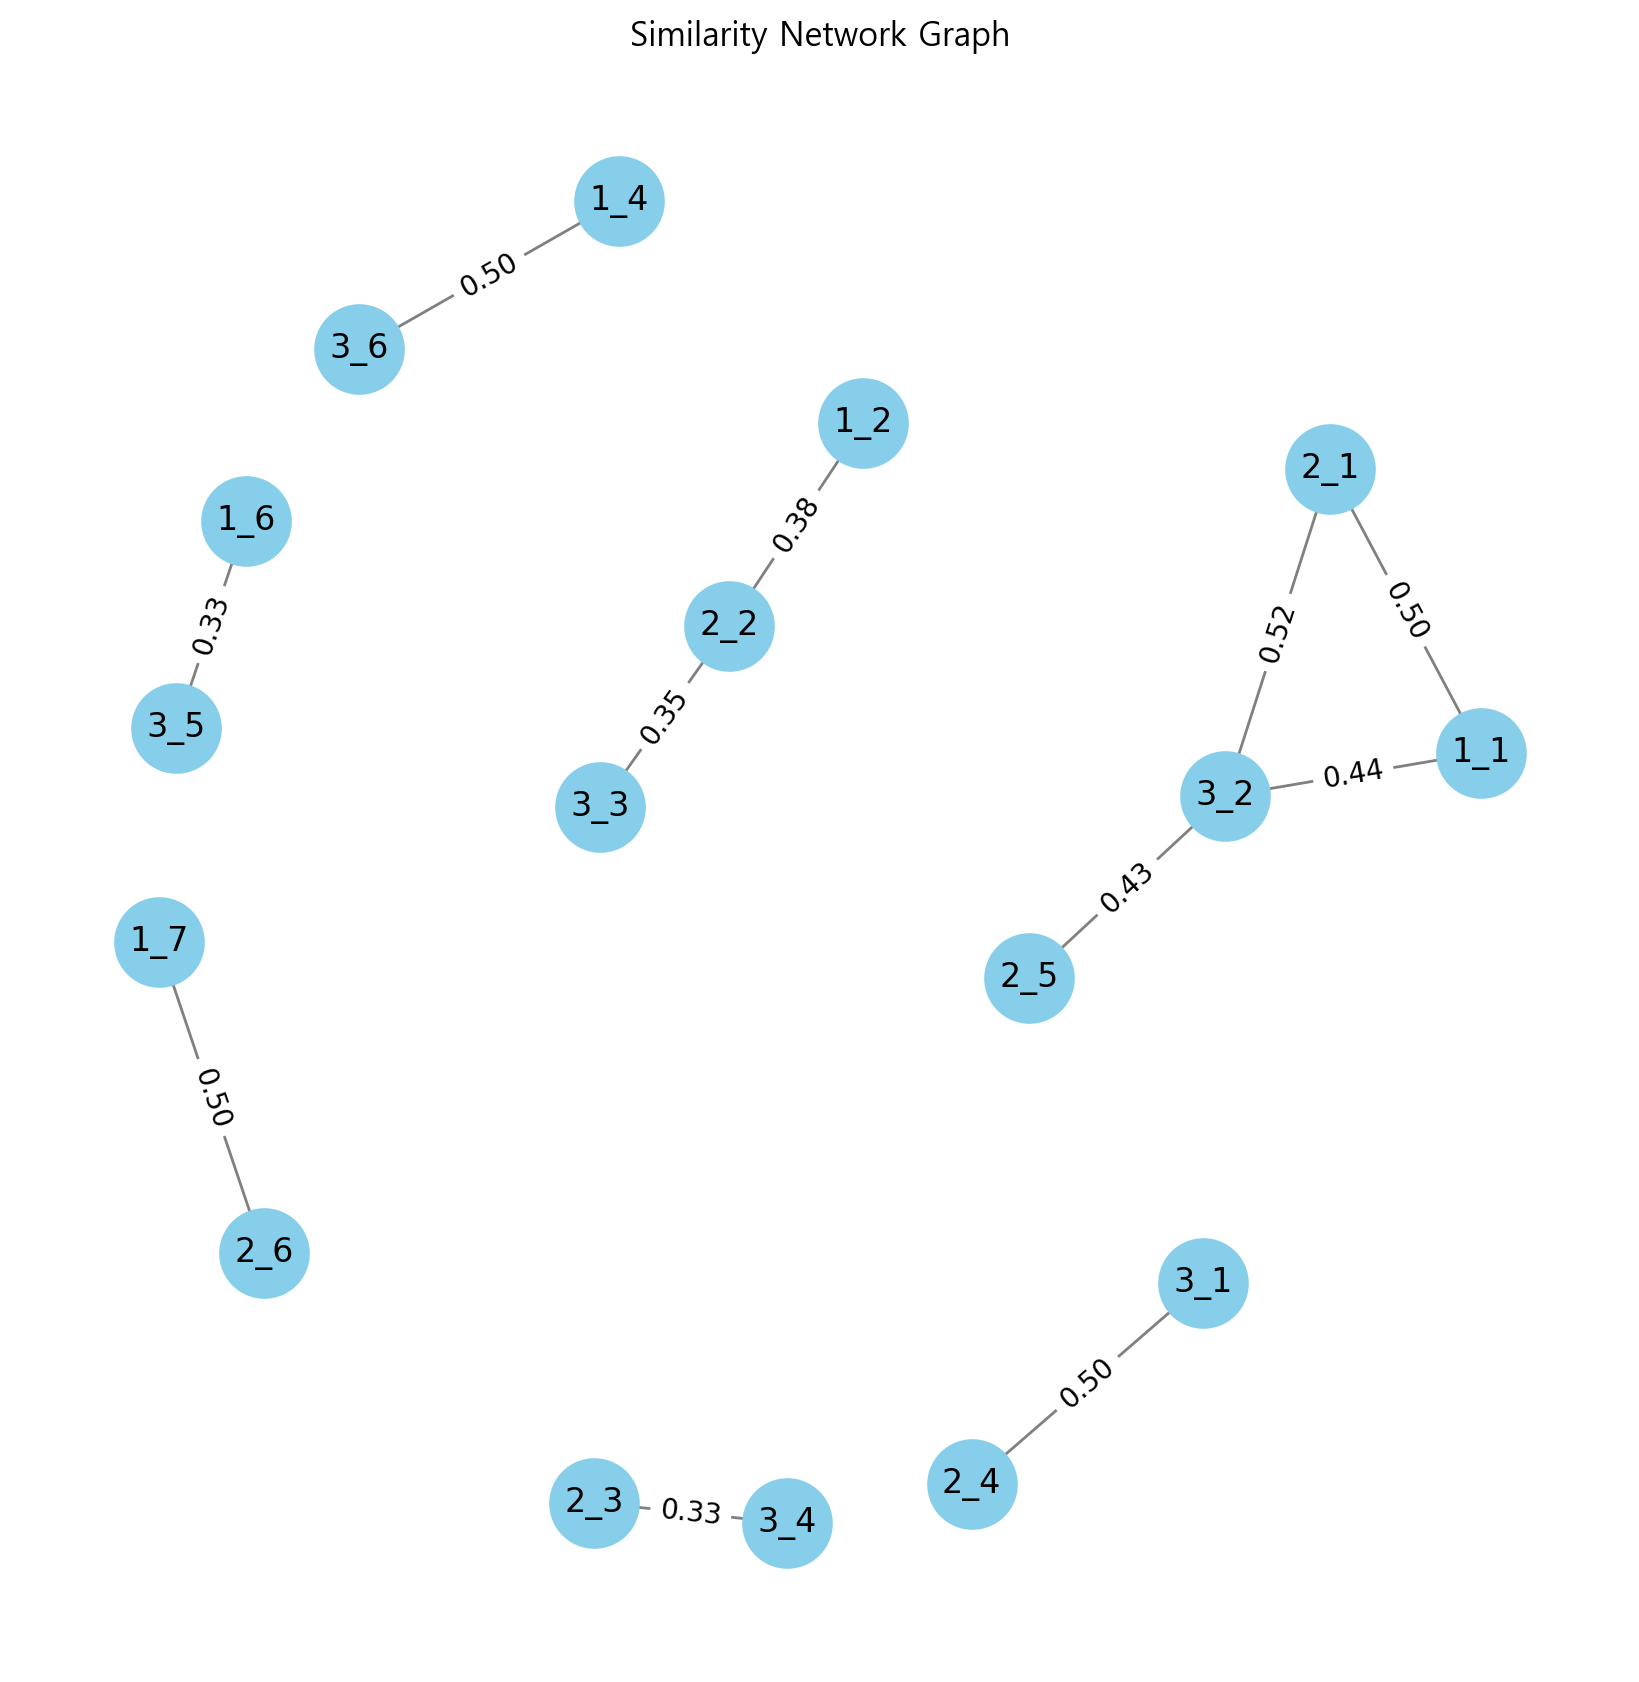

In [117]:
import networkx as nx

## 유사도가 0.33 이상인 경우만 필터링
filtered_df = filtered_similarity_df[filtered_similarity_df['Similarity'] >= 0.33]

# 연결망 그래프 생성
G = nx.Graph()

# 노드와 에지 추가
for index, row in filtered_df.iterrows():
    G.add_edge(row['Group1'], row['Group2'], weight=row['Similarity'])

# 그래프 크기를 1.5배 늘림
plt.figure(figsize=(8, 8))  # 기본 크기 대비 약 1.5배 크기로 설정

# 노드 위치 결정, kamada_kawai_layout 사용
pos = nx.kamada_kawai_layout(G)

# 노드와 에지 그리기
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='gray', font_size=12)

# 에지 라벨(유사도) 추가, 소수점 두 자리로 포매팅
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.title('Similarity Network Graph')
plt.axis('off')  # 축 숨기기
plt.show()

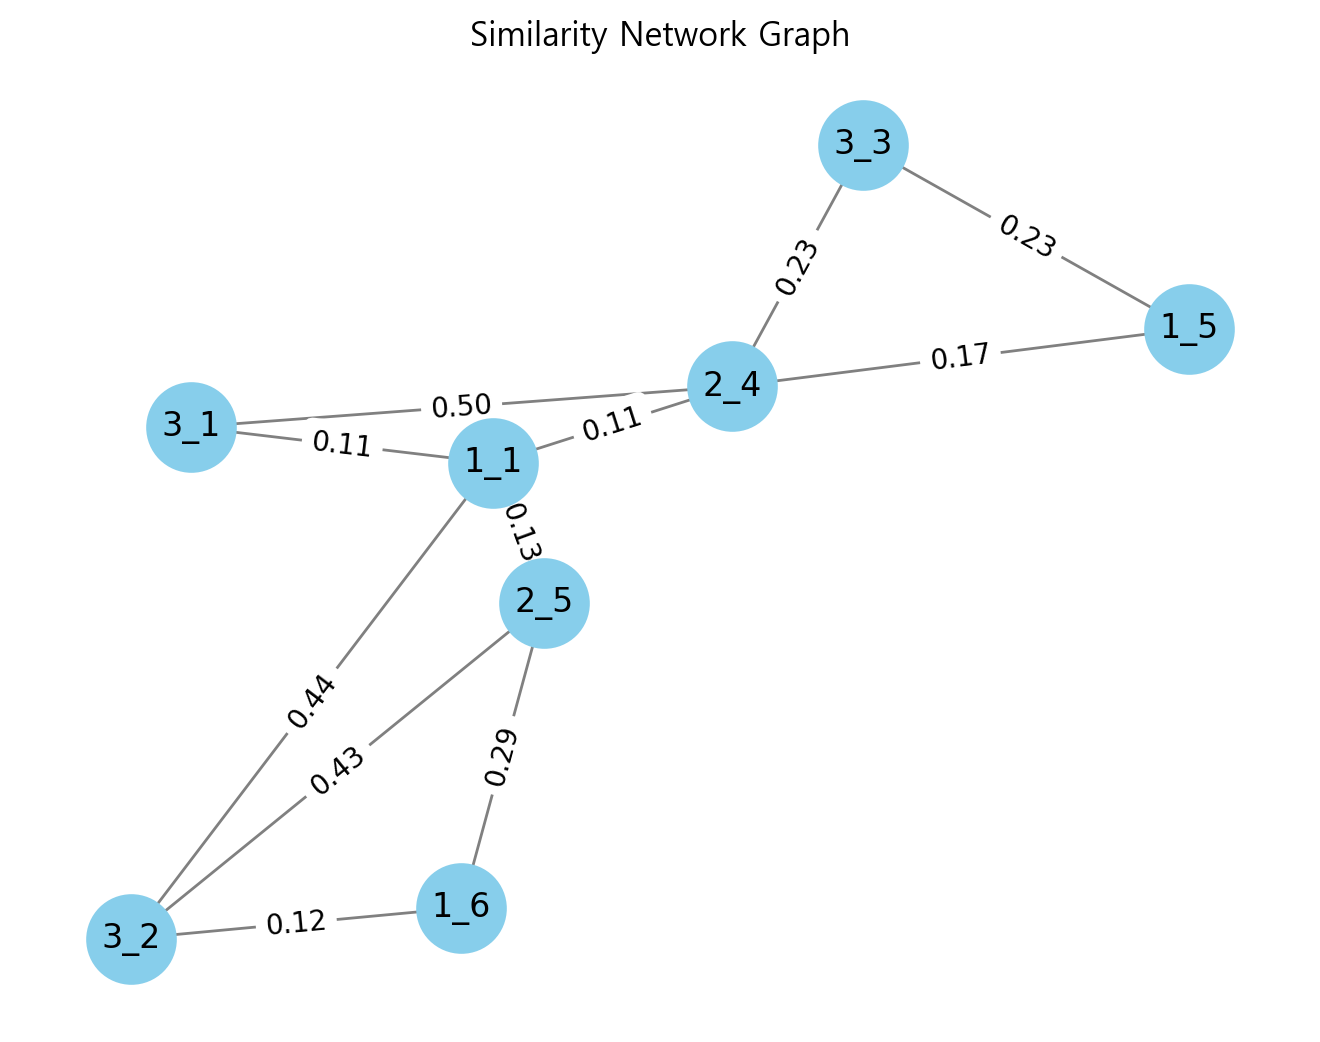

In [116]:
# 지정한 두 노드 및 이들과 거리 1에 있는 노드들만 포함하는 서브그래프 생성
n1 = '2_4'  # 예시 노드1
n2 = '2_5'  # 예시 노드2
subgraph1 = nx.ego_graph(G, n1, radius=1)
subgraph2 = nx.ego_graph(G, n2, radius=1)

# 두 서브그래프 합치기
subgraph = nx.compose(subgraph1, subgraph2)

# 노드 위치 결정
pos = nx.kamada_kawai_layout(subgraph)

# 노드와 에지 그리기
nx.draw(subgraph, pos, with_labels=True, node_color='skyblue', node_size=1000, edge_color='gray', font_size=12)

# 에지 라벨(유사도) 추가, 소수점 두 자리로 포매팅
edge_labels = {(u, v): f"{d['weight']:.2f}" for u, v, d in subgraph.edges(data=True)}
nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=edge_labels, font_size=10)

plt.title('Similarity Network Graph')
plt.axis('off')
plt.show()

In [119]:
# 최대 군집 간 비교 (유사도도 높음)

gp1 = '1_1' ; gp2 = '2_1' ; gp3 = '3_2'

common1 = [w for w in data[gp1] if w in (data[gp2])]
print(f"{gp1}~{gp2} common: {common1}")
common2 = [w for w in data[gp2] if w in (data[gp3])]
print(f"{gp2}~{gp3} common: {common2}")
common3 = [w for w in common1 if w in common2]
print(f"{gp1}~{gp2}~{gp3} common: {common3} \n")

1_1~2_1 common: ['主義', '개인', '사회', '시대', '자유', '정신', '제도', '현상']
2_1~3_2 common: ['主義', '국가', '사상', '사회', '시대', '자유', '제도', '조직', '필요', '현상']
1_1~2_1~3_2 common: ['主義', '사회', '시대', '자유', '제도', '현상'] 



In [125]:
# 사회주의 지표 파악

print(final_df.query('group == "2_4" or group == "2_5"'))
print(common3[:2])

                           node
group                          
2_4    [意識, 계급, 국제, 무산, 운동, 혁명]
2_5            [노동, 발달, 생산, 자본]
['主義', '사회']


# The End of Note